# Some very basic exploration of singular/plural endings

## Import modules and load dictionaries

*(Source: Wiktionary + https://github.com/karoly-varasdi/de-wiktionary-parser/ )*

In [1]:
import dewiktionaryparser as dw
import re
from copy import deepcopy
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## The dictionaries generated from Wiktionary are located in the data folder of the current working directory.

noun_entries = dw.GermanNounEntriesDict()
noun_entries.retrieve_from_json('.\data\de_noun_entries.json')
# noun_entries.retrieve_from_json('.\data\de_noun_entries_with_translations.json')
print("Main dictionary 'noun_entries' is available.\n")
noun_inv_dic = dw.WordEntriesDict()
noun_inv_dic.retrieve_from_json('.\data\de_noun_entries_inv.json')
print("Dictionary 'noun_inv_dic' mapping word form variants to their word forms is available.\n")
# noun_translations = dw.GermanNounTranslationDict()
# noun_translations.retrieve_from_json('.\data\de_noun_translations.json')
# print("Dictionary 'noun_translations' providing English translations is available.\n")
# noun_translations_inv_dic = dw.WordEntriesDict()
# noun_translations_inv_dic.retrieve_from_json('.\data\de_noun_translations_inv.json')
# print("Dictionary 'noun_translations_inv_dic' mapping English words to their possible German sources is available.\n")
commons = dw.WordEntriesDict()
commons.retrieve_from_json('.\data\de_noun_entries_commons.json')

Retrieving dictionary from .\data\de_noun_entries.json . . .


Retrieved 75940 entries.

Main dictionary 'noun_entries' is available.

Retrieving dictionary from .\data\de_noun_entries_inv.json . . .


Retrieved 200221 entries.

Dictionary 'noun_inv_dic' mapping word form variants to their word forms is available.

Retrieving dictionary from .\data\de_noun_entries_commons.json . . .


Retrieved 69558 entries.



## Statistics on singular / plural endings

Get list of all sg / pl ending (last letter) pairs:

In [4]:
sg_pl_ends_pair_list = []
for w in commons:
    try:
        sg_nom_lasts = [sg[-1] for sg in dw.leaves_by_path_fragment(commons[w], ['nominativ', 'singular'])]
        pl_nom_lasts = [pl[-1] for pl in dw.leaves_by_path_fragment(commons[w], ['nominativ', 'plural'])]
    except: # we are only interested in nouns for which both singular and plural nominativ forms are specified
        continue
    for sg in sg_nom_lasts:
        for pl in pl_nom_lasts:
            sg_pl_ends_pair_list.append((sg, pl))
            
# singular endings and plural endings:
sg_from_sg_pl_ends_list = [pair[0] for pair in sg_pl_ends_pair_list]
pl_from_sg_pl_ends_list = [pair[1] for pair in sg_pl_ends_pair_list]



## Get final sg/pl letters:

Text(0.5,0,'20 most common sg/pl ending pairs')

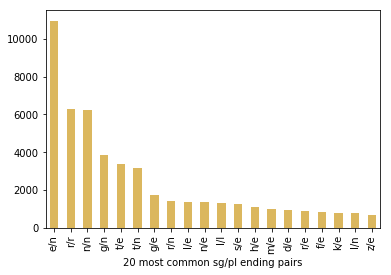

In [5]:

sg_pl_ends_str_list = []
for pair in sg_pl_ends_pair_list:
    sg_pl_ends_str_list.append(pair[0]+'/'+pair[1])

sg_pl_str_ends_df = pd.Series(sg_pl_ends_str_list)

sg_pl_str_ends_counter = sg_pl_str_ends_df.value_counts(sort=True)
sg_pl_str_ends_counter = sg_pl_str_ends_counter.rename_axis('sg/pl').to_frame('count')
fig = sg_pl_str_ends_counter['count'].head(20).plot.bar(logy=False, color=(0.8, 0.6, 0.1, 0.7))
fig.set_xlabel('20 most common sg/pl ending pairs')


## Singular ending by plural ending stats

In [6]:
sg_pl_end_df = pd.DataFrame({'last_sg': sg_from_sg_pl_ends_list, 'last_pl': pl_from_sg_pl_ends_list})
sg_pl_end_df['last_sg/last_pl'] = sg_pl_end_df['last_sg'] + '/' + sg_pl_end_df['last_pl']

# add count of 'last_sg/last_pl':
sg_pl_end_df = sg_pl_end_df.join(
        sg_pl_end_df['last_sg/last_pl'].value_counts().rename('pair_count'), 
        how="left", on='last_sg/last_pl')

# # add count of sg ending:
# sg_pl_end_df = sg_pl_end_df.join(
#         sg_pl_end_df['last_sg'].value_counts().rename('sg_count'), 
#         how="left", on='last_sg')
# 
# # add count of pl ending:
# sg_pl_end_df = sg_pl_end_df.join(
#         sg_pl_end_df['last_pl'].value_counts().rename('pl_count'), 
#         how="left", on='last_pl')

# add prob of sg ending:
sg_pl_end_df = sg_pl_end_df.join(
    (sg_pl_end_df['last_sg'].value_counts()/sg_pl_end_df['last_sg'].count()).rename('sg_prob'), 
        how="left", on='last_sg')

# add prob of pl ending:
sg_pl_end_df = sg_pl_end_df.join(
    (sg_pl_end_df['last_pl'].value_counts()/sg_pl_end_df['last_pl'].count()).rename('pl_prob'), 
        how="left", on='last_pl')

'''
calculate conditional probability of pl ending given sg ending P(last_pl | last_sg):
P(PL|SG) = count(SG, PL) / count(SG)
count(SG, PL) = sg_pl_end_df.groupby('last_pl')['last_sg'].value_counts()
count(PL) = sg_pl_end_df.groupby('last_pl')['last_sg'].count()
count(SG) = sg_pl_end_df.groupby('last_sg')['last_pl'].count()
'''
cond_prob_pl_given_sg_df = sg_pl_end_df.groupby('last_pl')['last_sg'].value_counts()/sg_pl_end_df.groupby('last_sg')['last_pl'].count()
cond_prob_pl_given_sg_df = cond_prob_pl_given_sg_df.to_frame('P(pl|sg)')

# calculate conditional probability of sg ending given pl ending P(last_sg | last_pl):
cond_prob_sg_given_pl_df = sg_pl_end_df.groupby('last_sg')['last_pl'].value_counts()/sg_pl_end_df.groupby('last_pl')['last_sg'].count()
cond_prob_sg_given_pl_df = cond_prob_sg_given_pl_df.to_frame('P(sg|pl)')

# add conditional probabilities to original df:
sg_pl_end_df = sg_pl_end_df.join(
        cond_prob_pl_given_sg_df, 
        how="left", on=['last_pl', 'last_sg'])
sg_pl_end_df = sg_pl_end_df.join(
        cond_prob_sg_given_pl_df, 
        how="left", on=['last_sg', 'last_pl'])

# sorting the df:
# sg_pl_end_df = sg_pl_end_df.sort_values(by='last_sg/last_pl')
sg_pl_end_df = sg_pl_end_df.sort_values(by='pair_count', ascending=False)
## should we want to check if join is correct and no NULL values appeared:
# sg_pl_end_df.isnull().sum()

# create dataframe with unique rows only:
sg_pl_end_uniqe_df = sg_pl_end_df.drop_duplicates()
## should we want to reindex the unique row df: 
# sg_pl_end_uniqe_df = sg_pl_end_uniqe_df.reset_index(drop=True)

# # to dump unique rows df to a csv file:
# sg_pl_end_uniqe_df.to_csv('.\data\last_sg_pl_letters_df.csv')

## Some basic overview of the unique rows df:
# print("The number of sg/pl ending types is {}.".format(len(sg_pl_end_uniqe_df)))
# sg_pl_end_uniqe_df.info()
sg_pl_end_uniqe_df.describe()


,pair_count,sg_prob,pl_prob,P(pl|sg),P(sg|pl)
count,183.000000,183.000000,183.000000,183.000000,183.000000
mean,332.852459,0.040925,0.123236,0.245902,0.191257
std,1138.533294,0.054605,0.161446,0.327326,0.333370
min,1.000000,0.000016,0.000016,0.000085,0.000061
25%,2.000000,0.002725,0.000558,0.004519,0.003960
50%,10.000000,0.016072,0.071365,0.056624,0.030136
75%,149.500000,0.039352,0.203966,0.439256,0.133333
max,10969.000000,0.193722,0.481498,1.000000,1.000000


### Tabulating types of endings

Excluding hapaxes, sorted primarily by probability of plural ending and conditional probability of plural ending given singular ending.

In [8]:
sg_pl_end_uniqe_df = sg_pl_end_uniqe_df.sort_values(by=['pl_prob', 'P(pl|sg)', 'P(sg|pl)', 'sg_prob',  'last_sg/last_pl'], ascending=[False, False, False, False, False])
sg_pl_end_uniqe_not_hapax_df = sg_pl_end_uniqe_df[sg_pl_end_uniqe_df['pair_count'] > 1]
sg_pl_end_uniqe_not_hapax_df


,last_sg,last_pl,last_sg/last_pl,pair_count,sg_prob,pl_prob,P(pl|sg),P(sg|pl)
25835,e,n,e/n,10969,0.193722,0.481498,0.929576,0.373998
21940,ö,n,ö/n,7,0.000131,0.481498,0.875000,0.000239
31346,n,n,n/n,6219,0.134309,0.481498,0.760176,0.212043
39575,g,n,g/n,3852,0.094333,0.481498,0.670379,0.131338
20924,u,n,u/n,140,0.004498,0.481498,0.510949,0.004773
54342,i,n,i/n,322,0.012247,0.481498,0.431635,0.010979
53188,t,n,t/n,3153,0.123769,0.481498,0.418225,0.107505
42428,a,n,a/n,317,0.015366,0.481498,0.338675,0.010808
4878,z,n,z/n,285,0.016828,0.481498,0.278049,0.009717
57067,m,n,m/n,512,0.031275,0.481498,0.268766,0.017457


### Correlations

In [9]:
# pairwise correlation
# sg_pl_end_uniqe_df.drop(['last_sg/last_pl'], axis=1).corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

corr_sg_pl_end_uniqe_df = sg_pl_end_uniqe_df.corr(method='spearman')

corr_sg_pl_end_uniqe_df



,pair_count,sg_prob,pl_prob,P(pl|sg),P(sg|pl)
pair_count,1.000000,0.429027,0.662893,0.382586,0.137592
sg_prob,0.429027,1.000000,0.127295,-0.510766,0.250883
pl_prob,0.662893,0.127295,1.000000,0.446329,-0.574629
P(pl|sg),0.382586,-0.510766,0.446329,1.000000,-0.127472
P(sg|pl),0.137592,0.250883,-0.574629,-0.127472,1.000000


### Plot P(pl|sg)

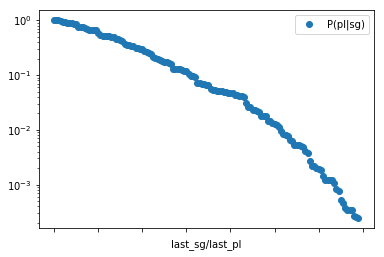

In [10]:
sg_pl_end_uniqe_not_hapax_df.sort_values(by=['P(pl|sg)', 'last_sg/last_pl'], ascending=[False, True]).plot(x='last_sg/last_pl', y='P(pl|sg)', style='o', logy=True)

## Plotting sg by pl final letters

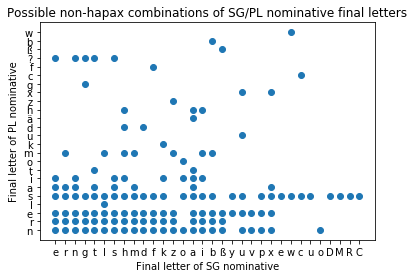

In [44]:
dfforplot = sg_pl_end_uniqe_not_hapax_df.sort_values(by=['pair_count', 'sg_prob', 'pl_prob', 'last_sg', 'last_pl'], ascending=[False, False, False, True, True])

arrayforplot = np.array(dfforplot[['last_sg', 'last_pl']])

xs = list(arrayforplot[:, 0])
ys = list(arrayforplot[:, 1])

plt.scatter(xs, ys)
plt.xlabel('Final letter of SG nominative')
plt.ylabel('Final letter of PL nominative')
plt.title('Possible non-hapax combinations of SG/PL nominative final letters')
plt.show()

## Statistics on singular endings

The 4 most common endings make up 59.4% of the endings of singlar nominative forms.


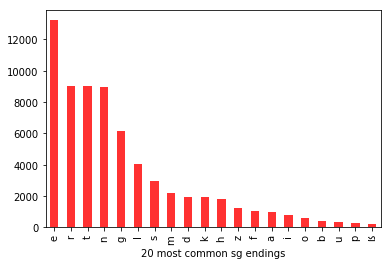

In [47]:

# sg_nom_last_g = [sg for sg in dw.leaves_by_path_fragment(commons, ['nominativ', 'singular']) if sg.endswith('g')]
sg_nom_last_list = [sg[-1] for sg in dw.leaves_by_path_fragment(commons, ['nominativ', 'singular'])]
sg_nom_last_df = pd.Series(sg_nom_last_list)
sg_nom_last_df = sg_nom_last_df.value_counts(sort=True)
sg_nom_last_df = sg_nom_last_df.rename_axis('last_sg').to_frame('count')
sg_nom_last_df.head(20)

fig = sg_nom_last_df['count'].head(20).plot.bar(logy=False, color=(1.0, 0.1, 0.1, 0.9))
fig.set_xlabel('20 most common sg endings')

sg_nom_last_head4_list = sg_nom_last_df.head(4)['count'].tolist()
print("The 4 most common endings make up {}% of the endings of singlar nominative forms.".format(round(sum(sg_nom_last_head4_list) / len(sg_nom_last_list) * 100, 1)))
# 0.5942676289635589